In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.chdir('../../')

In [3]:
from musicautobot.numpy_encode import *
from musicautobot.utils.file_processing import process_all, process_file
from musicautobot.config import *
from musicautobot.music_transformer import *
from musicautobot.multitask_transformer import *
from musicautobot.numpy_encode import stream2npenc_parts

/Users/andrewshaw/miniconda3/envs/midi/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# Generate Music with Pretrained Model

### Load Pretrained

In [4]:
# Config
config = multitask_config();

# Location of your midi files
midi_path =  Path('data/midi')

# Location of saved datset
data_path = Path('data/numpy')
data_save_name = 'musicitem_data_save.pkl'

In [5]:
# Data
data = load_data(data_path, data_save_name, bs=1)
vocab = data.vocab

/Users/andrewshaw/miniconda3/envs/midi/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [6]:
# Pretrained Model
# Download pretrained model if you haven't already
pretrained_url = 'https://ashaw-midi-web-server.s3-us-west-2.amazonaws.com/pretrained'
pretrained_path = untar_data(pretrained_url, dest=data_path)
load_path = pretrained_path/'MultitaskTransformer.pth'; load_path

PosixPath('data/numpy/pretrained/MultitaskTransformer.pth')

In [7]:
# Learner
learn = multitask_model_learner(data, config.copy(), pretrained_path=load_path)
# learn.to_fp16();

### Choose existing midi file as a starting point

In [8]:
example_dir = midi_path/'examples'
midi_files = get_files(example_dir, recurse=True, extensions='.mid'); midi_files

[PosixPath('data/midi/examples/Levels - Avicii - Verse.mid'),
 PosixPath('data/midi/examples/Scary Monsters And Nice Sprites - Skrillex - Pre-Chorus.mid'),
 PosixPath('data/midi/examples/Can You Feel The Love Tonight - Elton John - Verse.mid'),
 PosixPath('data/midi/examples/Locked Out Of Heaven - Bruno Mars - Chorus.mid'),
 PosixPath('data/midi/examples/In The Hall Of The Mountain King - Edvard Grieg - Intro.mid'),
 PosixPath('data/midi/examples/Colors Of The Wind - Disney - Chorus.mid'),
 PosixPath('data/midi/examples/I Want You Back - Jackson 5 - Intro.mid'),
 PosixPath('data/midi/examples/Fuer Elise - Ludwig Van Beethoven - Verse.mid'),
 PosixPath('data/midi/examples/A Thousand Miles - Vanessa Carlton - Verse-And-Pre-Chorus.mid'),
 PosixPath('data/midi/examples/The Four Seasons Concerto No 4 Winter - Antonio Vivaldi - Instrumental.mid'),
 PosixPath('data/midi/examples/La Bamba - Ritchie Valen - Chorus.mid'),
 PosixPath('data/midi/examples/Just Give Me A Reason - Pink - Chorus.mid')

In [9]:
file = midi_files[10]; file

PosixPath('data/midi/examples/La Bamba - Ritchie Valen - Chorus.mid')

In [10]:
# Encode file 
item = MusicItem.from_file(file, data.vocab)

x = item.to_tensor()
x_pos = item.get_pos_tensor()

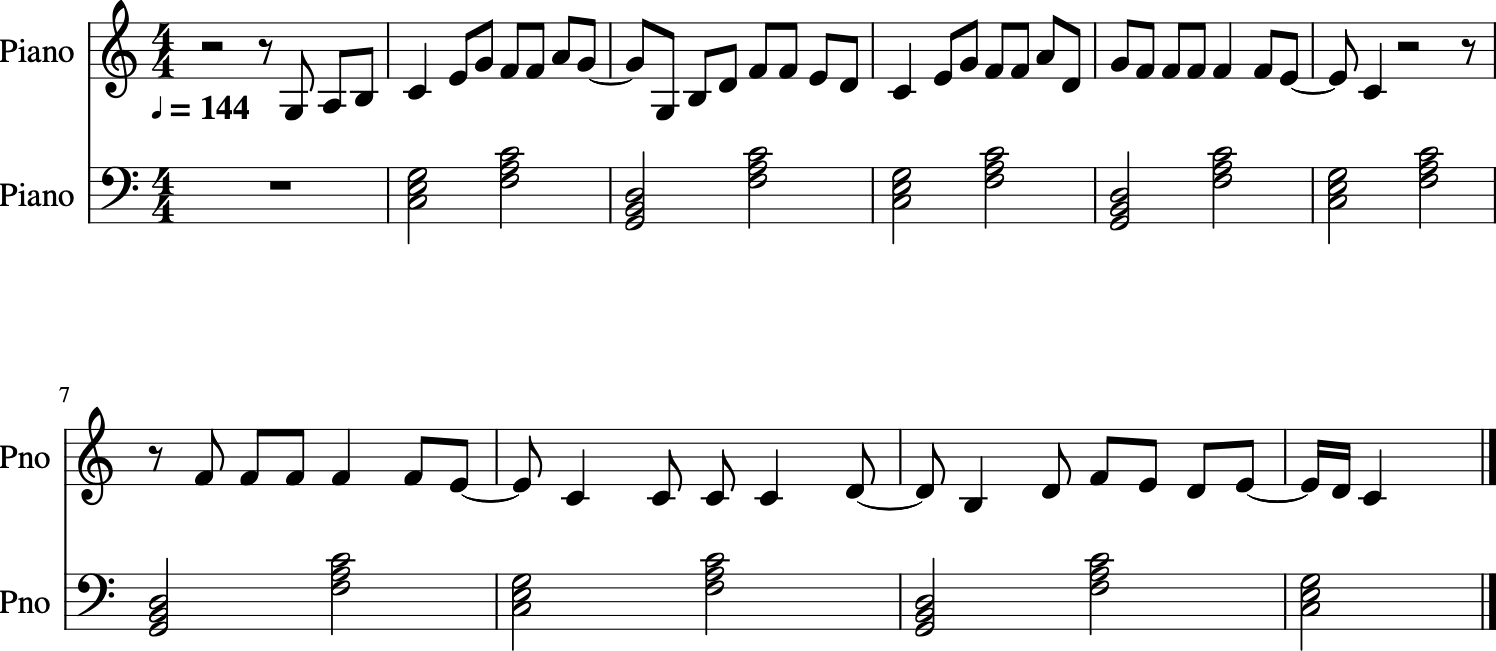

In [11]:
item.show()

In [12]:
item.play()

## Generate

MultitaskTransformer trains on 3 separate tasks. 
1. NextWord
2. Mask
3. Sequence to Sequence

Because we train on 3 separate tasks, we can actually generate some really cool note sequences.

1. NextWord/Autocomplete - Take a sequence of notes and predict the next note
 * 1a. Vanilla Language Model predictions - See [MusicTransformer](../music_transformer) project


2. Mask/Remix - Mask certain parts of song and remix those portions.
 * 2a. Note Masking - Mask all the note pitches and create a new sequence with different notes, but same exact rhythm
 * 2b. Duration Masking - Mask the note durations. Generate a new sequence with the same melody, but with a different rhythm


3. Seq2Seq/Translation - Generate melody from chords or vice versa. 
 * 3a. New Melody - Generate a new melody from existing chords
 * 3b. Harmonization - Generate chords to acompany an existing melody

## 1. NextWord/Autocomplete

Trim the song to only a few notes. Model will use these notes a seed and continue the idea

In [51]:
seed_len = 6 # 4 beats = 1 bar
seed = item.trim_to_beat(seed_len)

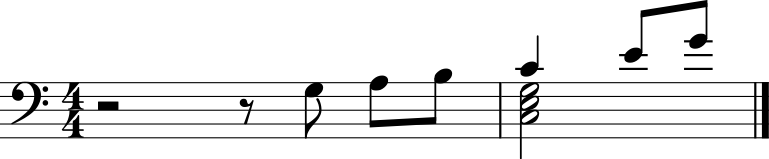

In [52]:
seed.show()

In [59]:
pred, full = learn.predict_nw(seed, n_words=200, top_p=0.95, top_k=24)

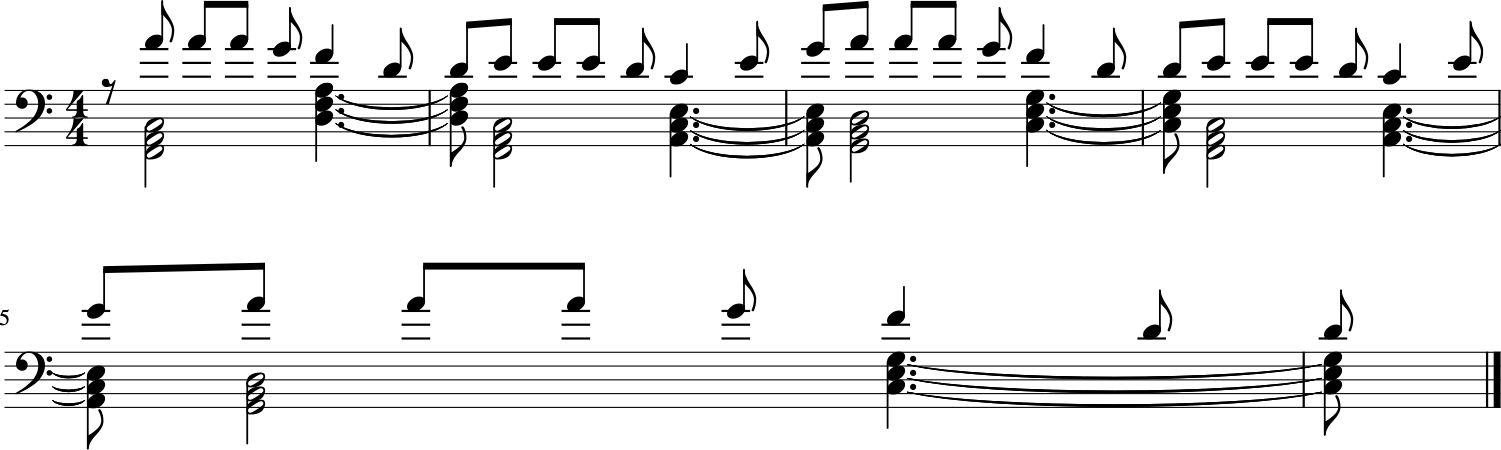

In [60]:
pred.show()

In [61]:
pred.play()

Add more randomness

Predicted BOS token. Returning prediction...


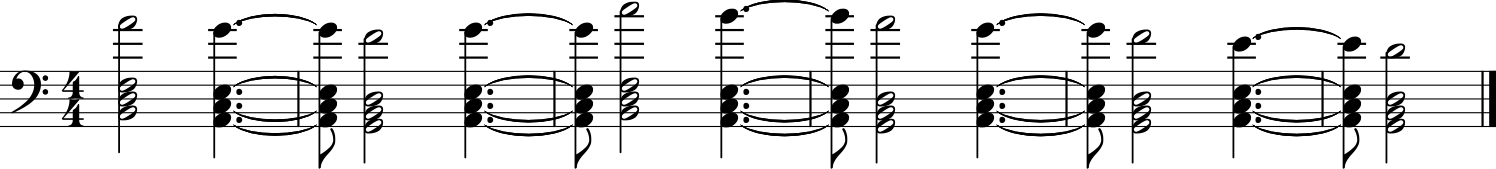

In [169]:
pitch_temp = 1.2 # randomness of melody
tempo_temp = 0.8 # randomness or rhythm
top_k = 40
pred_nw, full = learn.predict_nw(seed, temperatures=(pitch_temp, tempo_temp), top_k=top_k, top_p=0.9)
pred_nw.show()

In [62]:
# Convenience function
# out = nw_predict_from_midi(learn, file, seed_len=seed_len, top_k=30, top_p=0.5); out.show()

## 2. Mask/Remix

### 2a. Remix Notes

Mask all the note pitches. Model will create a new song with the same rhythm

In [168]:
### Mask notes
note_item = item.mask_pitch();

In [209]:
# Mask vs Original
list(zip(note_item.to_text(None)[:20], item.to_text(None)[:20]))

[('xxbos', 'xxbos'),
 ('xxpad', 'xxpad'),
 ('xxsep', 'xxsep'),
 ('d10', 'd10'),
 ('xxmask', 'n55'),
 ('d2', 'd2'),
 ('xxsep', 'xxsep'),
 ('d2', 'd2'),
 ('xxmask', 'n57'),
 ('d2', 'd2'),
 ('xxsep', 'xxsep'),
 ('d2', 'd2'),
 ('xxmask', 'n59'),
 ('d2', 'd2'),
 ('xxsep', 'xxsep'),
 ('d2', 'd2'),
 ('xxmask', 'n60'),
 ('d4', 'd4'),
 ('xxmask', 'n55'),
 ('d8', 'd8')]

In [ ]:
np.log(np.arange(10))/5

In [210]:
pred_note = learn.predict_mask(note_item, temperatures=(1.2, 0.), top_k=24, top_p=0.9)

p removed: 4
p removed: 9
p removed: 13
p removed: 10
p removed: 17
p removed: 18
p removed: 20
p removed: 14
p removed: 16
p removed: 15
p removed: 17
p removed: 17
p removed: 19
p removed: 17
p removed: 19
p removed: 19
p removed: 16
p removed: 22
p removed: 22
p removed: 15
p removed: 20
p removed: 23
p removed: 18
p removed: 23
p removed: 23
p removed: 22
p removed: 20
p removed: 22
p removed: 20
p removed: 16
p removed: 23
p removed: 23
p removed: 22
p removed: 17
p removed: 19
p removed: 18
p removed: 23
p removed: 23
p removed: 23
p removed: 20
p removed: 21
p removed: 21
p removed: 15
p removed: 23
p removed: 23
p removed: 23
p removed: 19
p removed: 21
p removed: 21
p removed: 18
p removed: 23
p removed: 23
p removed: 23
p removed: 19
p removed: 21
p removed: 17
p removed: 22
p removed: 22
p removed: 21
p removed: 13
p removed: 22
p removed: 23
p removed: 13
p removed: 22
p removed: 23
p removed: 19
p removed: 22
p removed: 19
p removed: 17
p removed: 23
p removed: 23
p remove

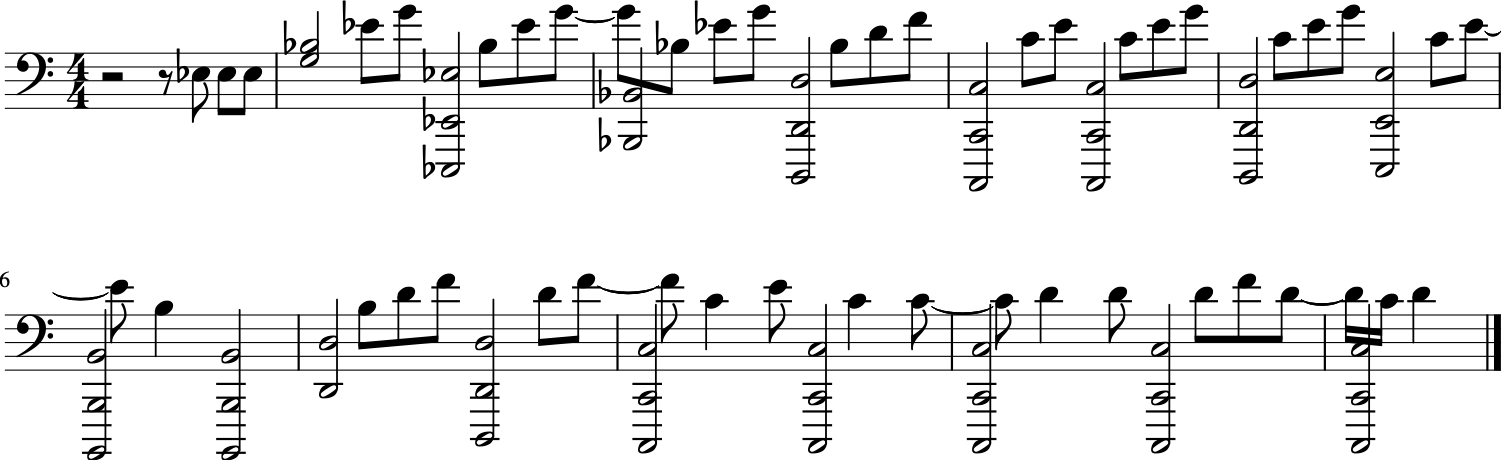

In [211]:
pred_note.show()

In [212]:
pred_note.play()

### 2b. Remix rhythm

Mask note durations. Same notes, different rhythm

In [213]:
# duration mask
dur_item = item.mask_duration()

In [214]:
# Mask vs Original
list(zip(dur_item.to_text(None)[:10], item.to_text(None)[:10]))

[('xxbos', 'xxbos'),
 ('xxpad', 'xxpad'),
 ('xxsep', 'xxsep'),
 ('xxmask', 'd10'),
 ('n55', 'n55'),
 ('xxmask', 'd2'),
 ('xxsep', 'xxsep'),
 ('xxmask', 'd2'),
 ('n57', 'n57'),
 ('xxmask', 'd2')]

In [218]:
dur_pred = learn.predict_mask(dur_item, temperatures=(0.,1.2), top_k=24, top_p=0.9)

p removed: 13
p removed: 17
p removed: 20
p removed: 21
p removed: 21
p removed: 18
p removed: 23
p removed: 15
p removed: 17
p removed: 23
p removed: 23
p removed: 23
p removed: 22
p removed: 22
p removed: 20
p removed: 21
p removed: 21
p removed: 21
p removed: 23
p removed: 23
p removed: 21
p removed: 22
p removed: 23
p removed: 22
p removed: 23
p removed: 20
p removed: 23
p removed: 18
p removed: 23
p removed: 23
p removed: 22
p removed: 19
p removed: 23
p removed: 22
p removed: 23
p removed: 21
p removed: 23
p removed: 23
p removed: 22
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 22
p removed: 23
p removed: 23
p removed: 23
p removed: 22
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 18
p removed: 23
p removed: 23
p remo

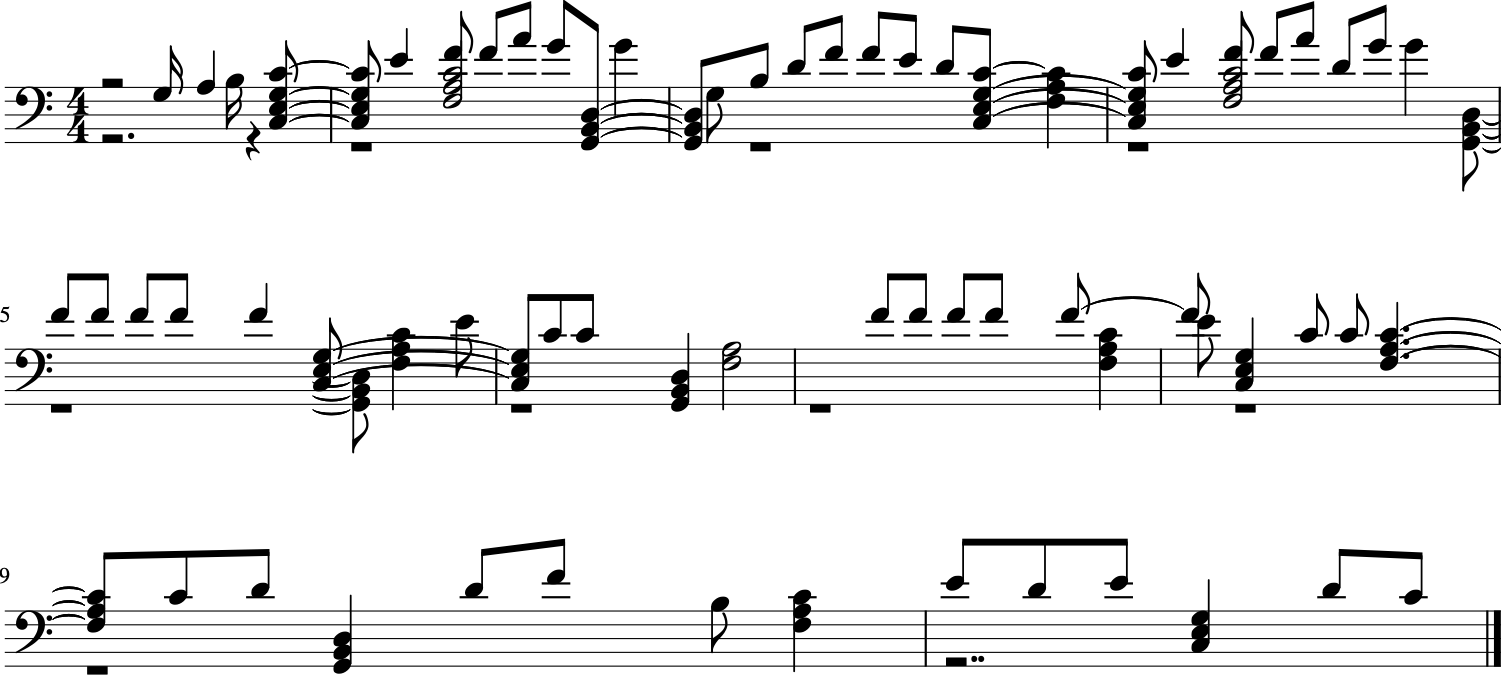

In [219]:
dur_pred.show()

In [220]:
dur_pred.play()

In [29]:
# Convenience function
# out = mask_predict_from_midi(learn, file, predict_notes=True)

## 3. Seq2Seq/Translation

Load MultitrackItem.

MultitrackItem keeps track of which notes are part of the melody and which notes are part of the chords.  
This info is needed for translation task

In [63]:
multitrack_item = MultitrackItem.from_file(file, vocab)

In [64]:
melody, chords = multitrack_item.melody, multitrack_item.chords

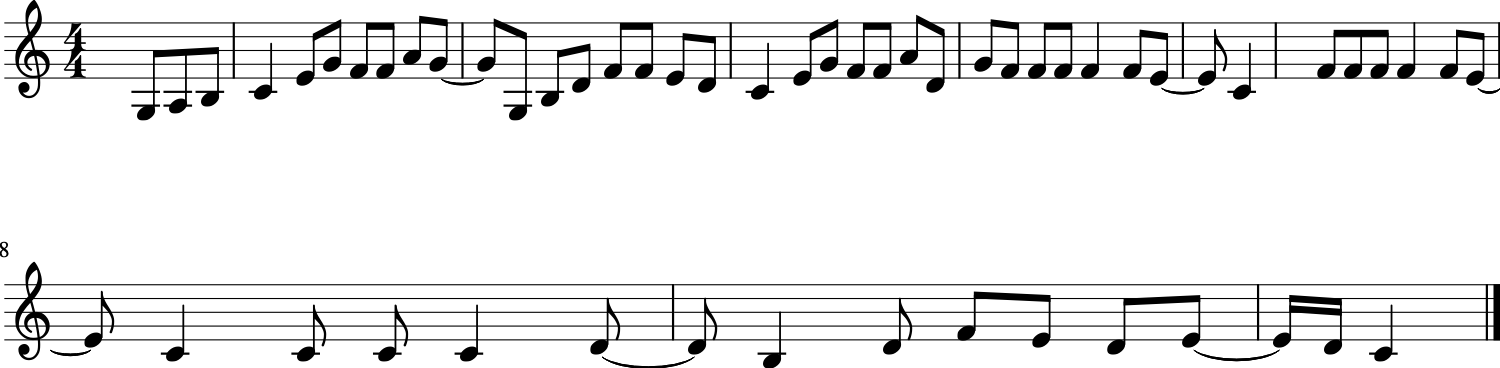

In [65]:
melody.show()

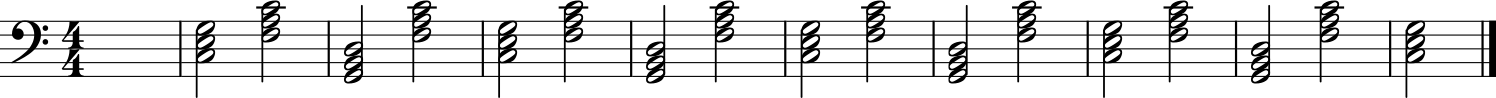

In [66]:
chords.show()

In [67]:
multitrack_item.play()

## 3a. Create Melody

Use existing chord progression to generate a new melody

In [230]:
# Use a seed for the melody
partial_melody = melody.trim_to_beat(4)

# Or generate from an empty sequence
empty_melody = MusicItem.empty(vocab, seq_type=SEQType.Melody)

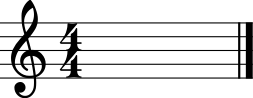

In [246]:
seed_melody = empty_melody; seed_melody.show()

In [252]:
seed_melody.to_text()

'xxmseq xxpad'

p removed: 9
p removed: 16
p removed: 20
p removed: 22
p removed: 14
p removed: 20
p removed: 23
p removed: 23
p removed: 16
p removed: 20
p removed: 23
p removed: 23
p removed: 15
p removed: 21
p removed: 23
p removed: 23
p removed: 16
p removed: 18
p removed: 23
p removed: 23
p removed: 17
p removed: 20
p removed: 23
p removed: 23
p removed: 17
p removed: 21
p removed: 23
p removed: 22
p removed: 17
p removed: 21
p removed: 23
p removed: 22
p removed: 15
p removed: 20
p removed: 23
p removed: 23
p removed: 16
p removed: 21
p removed: 23
p removed: 23
p removed: 17
p removed: 21
p removed: 23
p removed: 23
p removed: 17
p removed: 22
p removed: 23
p removed: 23
p removed: 19
p removed: 17
p removed: 23
p removed: 18
p removed: 13
p removed: 21
p removed: 23
p removed: 23
p removed: 19
p removed: 21
p removed: 23
p removed: 23
p removed: 20
p removed: 22
p removed: 23
p removed: 23
p removed: 17
p removed: 20
p removed: 23
p removed: 21
p removed: 17
p removed: 22
p removed: 23
p remov

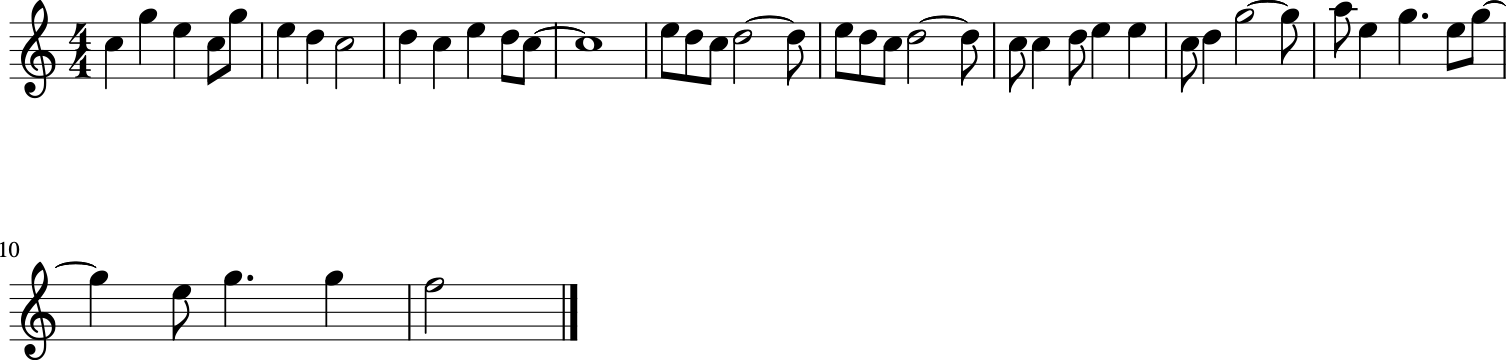

In [253]:
pred_melody = learn.predict_s2s(chords, seed_melody, use_memory=True, temperatures=(1.4, 1.2), top_k=24, top_p=0.9)
pred_melody.show()

In [254]:
pred_melody.play()

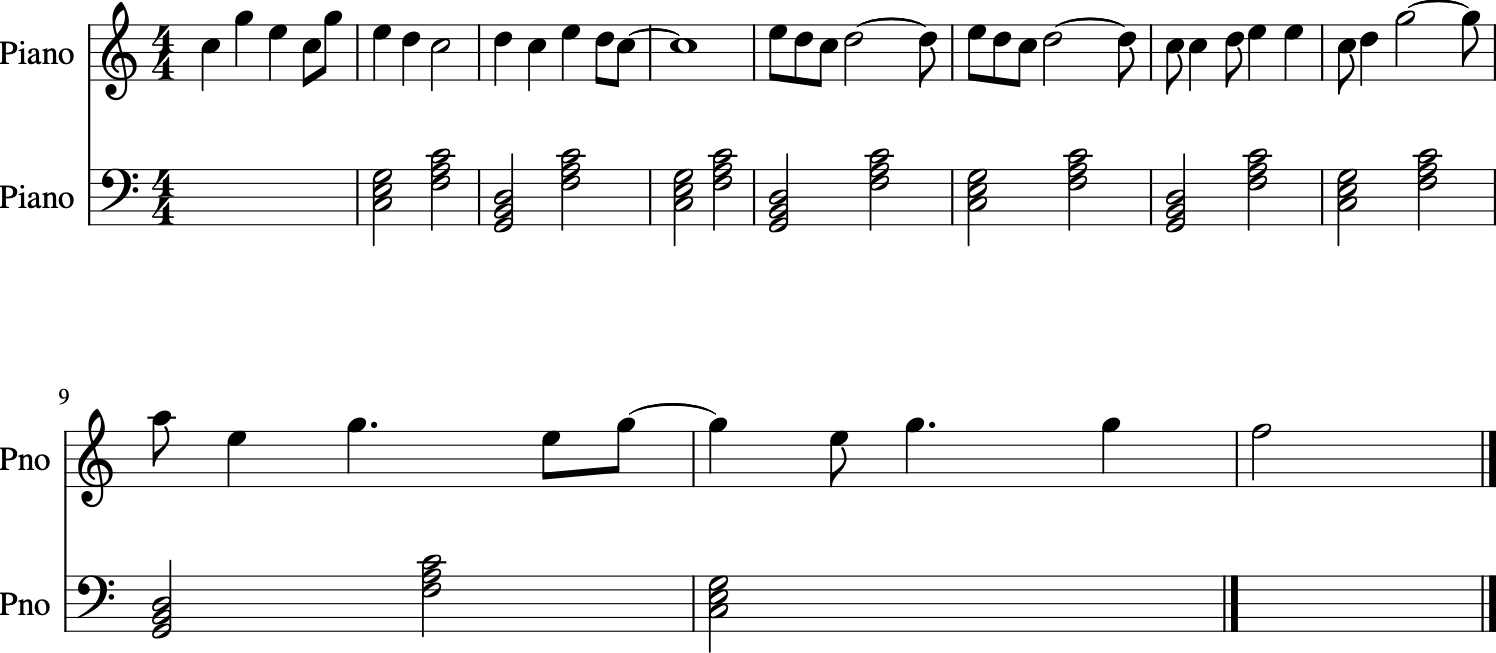

In [255]:
combined = MultitrackItem(pred_melody, chords)
combined.show()

In [256]:
combined.play()

## 3b. Harmonization

Generate chords to accompany an existing melody

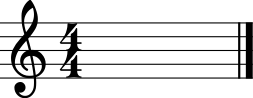

In [221]:
# partial_chords = chords.trim_to_beat(3);
# partial_chords.show()

empty_chords = MusicItem.empty(vocab, seq_type=SEQType.Chords); empty_chords.show()

In [239]:
pred_chord = learn.predict_s2s(input_item=melody, target_item=empty_chords, temperatures=(0.8, 0.8), top_k=12, top_p=0.9)

p removed: 20
p removed: 19
p removed: 19
p removed: 20
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 18
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 20
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 19
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 21
p removed: 23
p removed: 22
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 20
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 21
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p removed: 23
p remo

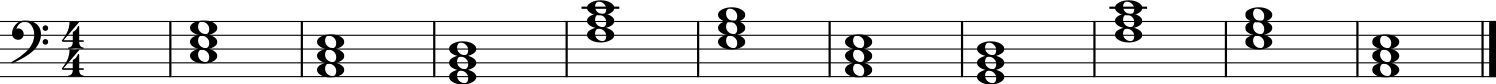

In [240]:
pred_chord.show()

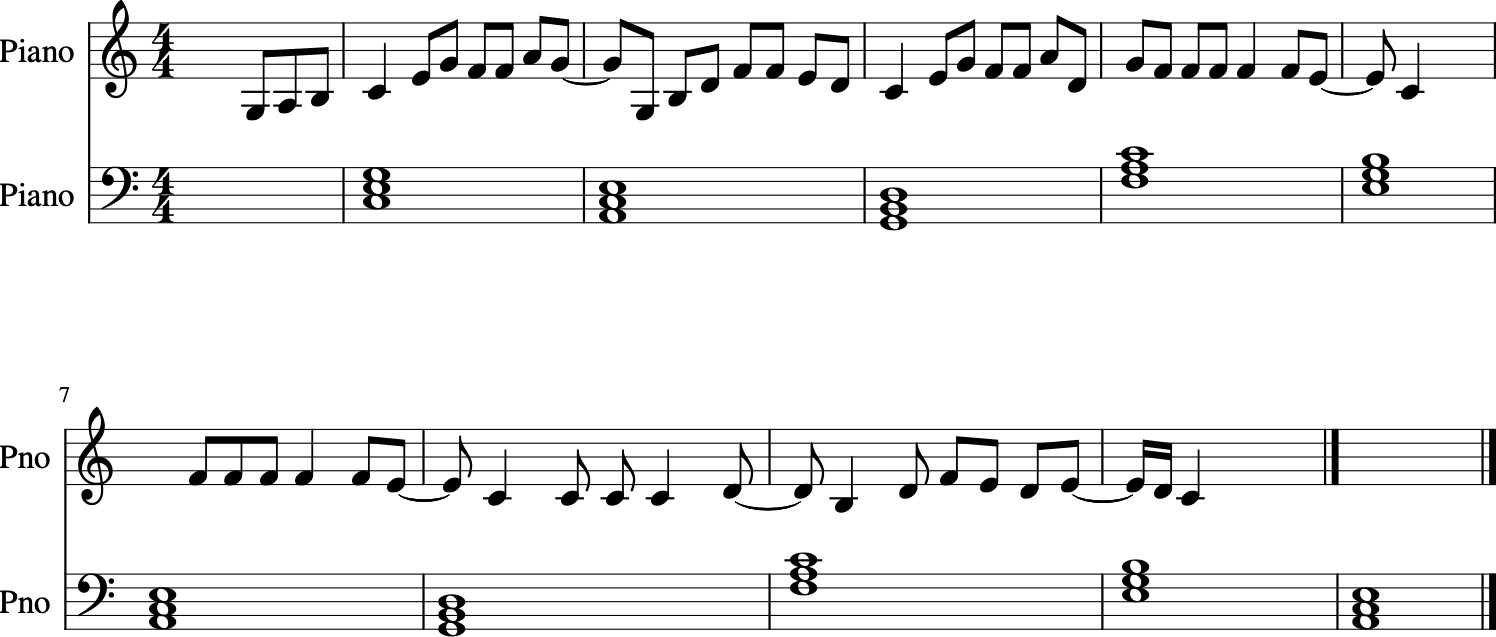

In [241]:
combined = MultitrackItem(melody, pred_chord)
combined.show()

In [229]:
combined.play()

In [45]:
# Convenience Function

# out = s2s_predict_from_midi(learn, file, seed_len=10); out.show()